In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [8]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'awake': 'darkviolet',
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [10]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load subjects from file

In [11]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [12]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and sensory stimulation

SSp_deep

 569073
Experiment type: electr

In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\burst_analyses'

## Test one subject

### Get stim-evoked spikes and analyze

In [14]:
## Parameters ##
apply_car = True

time_bin = 0.001 # size of time bins (s)

current_levels = ['low', 'medium', 'high']

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']

In [21]:
group = 'MOs_deep'
mouse_num = '569069' # could also try 569069, 569062

stim_area = group[:2]
stim_depth = group.split('_')[-1]
mdata = multi_sub_dict[group][mouse_num]
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

## Load unit info ##
fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
#     continue

## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
try:
    bad_chs = mdata['bad_chs']
except KeyError:
    badchstr = exp_meta['EEG bad_channels'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
        
## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
event_window = all_unit_event_spikes['event_window']
bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
mdata['good_chs'] = GOOD_CHS

## Get event inds ##
all_event_inds = {}
for leveli, parami in zip(current_levels, currents_list):
    all_event_inds[leveli] = {}
    for statei in ['awake', 'anesthetized']:
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
        state_events = []
        for sweepi in sweeps:
            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
            if len(events) == 0:
                continue
            state_events.append(events)
        all_event_inds[leveli][statei] = np.concatenate(state_events)
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][substatei] = np.concatenate(state_events)

## Get evoked EEG traces ##
EEG_traces = {}
for leveli, states_event_times in all_event_inds.items():
    EEG_traces[leveli] = {}
    for statei, event_inds in states_event_times.items():
        event_traces = all_EEG_traces[:, :, event_inds]
        ## Apply common avg ##
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]

## Population units ##
reg_unit_info = {}
for region in areas_of_interest.keys():
    if region in ctx_regions:
        regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
    else:
        regdf = unit_info[unit_info['parent'] == region]
    if len(regdf) > 8:
        reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)

start = time.time()
## Loop through regions/units to get event-related spike times ##
pop_event_spikes = {}
unit_event_spikes = {}
unit_event_bursts = {}
for leveli, states_event_times in all_event_inds.items():
    pop_event_spikes[leveli] = {}
    unit_event_spikes[leveli] = {}
    unit_event_bursts[leveli] = {}
    for statei, event_inds in states_event_times.items():
        pop_event_spikes[leveli][statei] = {}
        unit_event_spikes[leveli][statei] = {}
        unit_event_bursts[leveli][statei] = {}
        for regi, regdf in reg_unit_info.items():
            ## Get population event spike times ##
            pop_raster = []
            for eventi in event_inds:
                event_spikes = []
                for ii, unitrow in regdf.iterrows():
                    event_spikes.append(all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi])
                pop_raster.append(np.sort(np.concatenate(event_spikes)))
            pop_event_spikes[leveli][statei][regi] = pop_raster
            
            ## Get unit event spike times ##
            for ii, unitrow in regdf.iterrows():
                unit_event_spikes[leveli][statei][unitrow.unit_id] = \
                    [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                unit_event_bursts[leveli][statei][unitrow.unit_id] = {
                    'times': [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds],
                    'counts': [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['counts'][ei] for ei in event_inds]
                }

del all_unit_event_spikes, all_EEG_traces, EEG_event_timestamps
end = time.time()
print('Time to get event spike times: {:.2f} s'.format(end-start))

Time to get event spike times: 19.63 s


In [16]:
len(reg_unit_info['MO-TH'])

129

In [17]:
np.unique(reg_unit_info['MO-TH']['region'].values)

array(['VAL', 'VPL', 'VPM'], dtype=object)

In [18]:
np.sum(reg_unit_info['MO-TH']['region'].values == 'VAL')

39

In [19]:
len(pop_event_spikes['medium']['awake']['MO'])

120

### Investigating bursts

How many neurons burst on any one trial?

<IPython.core.display.Javascript object>


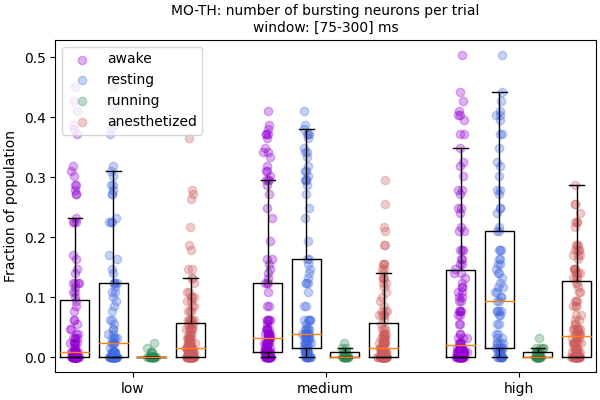

In [19]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
test_window = [0.075, 0.3] # [0.075, 0.3] [0, 0.05]
regi = 'MO-TH'
total_units = len(reg_unit_info[regi])
barlocs = np.arange((len(state_colors) + 1) * len(current_levels)).reshape((len(current_levels), (len(state_colors) + 1)))

for aa, (leveli, states_event_times) in enumerate(all_event_inds.items()):
    scatlegend = []
    for bb, (statei, einds) in enumerate(states_event_times.items()):
        unit_counts = np.zeros(len(einds), dtype=int)
        for jj in range(len(einds)):
            uc = 0
            for ii, unitrow in reg_unit_info[regi].iterrows():
                uid = unitrow.unit_id
                uburstsi = np.array(unit_event_bursts[leveli][statei][uid]['times'][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    uc += 1
            unit_counts[jj] = uc
        
        ax.boxplot(unit_counts/total_units, positions=[barlocs[aa, bb]], widths=[0.75], showfliers=False)
        xs = np.random.normal(barlocs[aa, bb], 0.05, len(unit_counts))
        dots = ax.scatter(xs, unit_counts/total_units, c=state_colors[statei], alpha=0.3, label=statei)
        scatlegend.append(dots)
        
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(current_levels)
ax.set_ylabel('Fraction of population')
ax.set_title('{}: number of bursting neurons per trial\nwindow: [{}-{}] ms'.format(
    regi, int(test_window[0]*1E3), int(test_window[1]*1E3)))
ax.legend(handles=scatlegend)

## Save ##
figname = 'popfractionbursting_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

On how many trials do neurons burst?

<IPython.core.display.Javascript object>


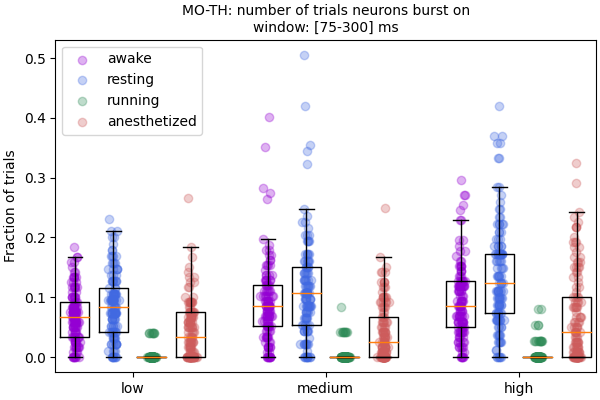

In [20]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
# test_window = [0.075, 0.3]
regi = 'MO-TH'
total_units = len(reg_unit_info[regi])
barlocs = np.arange((len(state_colors) + 1) * len(current_levels)).reshape((len(current_levels), (len(state_colors) + 1)))

for aa, (leveli, states_event_times) in enumerate(all_event_inds.items()):
    scatlegend = []
    for bb, (statei, einds) in enumerate(states_event_times.items()):
        unit_counts = np.zeros(total_units, dtype=float)
        for ii, unitrow in reg_unit_info[regi].iterrows():
            uid = unitrow.unit_id
            trial_counts = np.zeros(len(einds), dtype=int)
            for jj in range(len(einds)):
                uburstsi = np.array(unit_event_bursts[leveli][statei][uid]['times'][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    trial_counts[jj] = 1
            unit_counts[ii] = np.mean(trial_counts)
        
        ax.boxplot(unit_counts, positions=[barlocs[aa, bb]], widths=[0.75], showfliers=False)#, showmeans=True)
        xs = np.random.normal(barlocs[aa, bb], 0.05, len(unit_counts))
        dots = ax.scatter(xs, unit_counts, c=state_colors[statei], alpha=0.3, label=statei)
        scatlegend.append(dots)
        
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(current_levels)
ax.set_ylabel('Fraction of trials')
ax.set_title('{}: number of trials neurons burst on\nwindow: [{}-{}] ms'.format(
    regi, int(test_window[0]*1E3), int(test_window[1]*1E3)))
ax.legend(handles=scatlegend)

## Save ##
figname = 'trialfractionbursting_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Burst PSTH for one neuron

In [23]:
uid = 'B57'
pstim = 'medium'
pstate = 'resting'
tbin = 0.025
bbbins = np.arange(-2.0, 2.0 + tbin, tbin)

events = all_event_inds[pstim][pstate]
ubursts = unit_event_bursts[pstim][pstate][uid]['times']

burst_count, bedges = np.histogram(np.concatenate(ubursts), bbbins)
burst_rate = burst_count / (tbin * len(ubursts))
blmean = np.mean(burst_rate[bbbins[:-1] < 0])
blstd = np.std(burst_rate[bbbins[:-1] < 0])

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.bar(x=bbbins[:-1], height=burst_rate, width=tbin)
ax.axvline(0, color='k', linestyle='dashed', alpha=0.5)
ax.axhspan(0, blmean+(3*blstd), color='m', alpha=0.1)
ax.set_ylabel('Burst rate (Hz)')
ax.set_xlabel('Time from stim onset (s)')
ax.set_title('{}: {} stim, {}'.format(uid, pstim, pstate))

KeyError: 'B57'

In [70]:
precount = np.zeros(len(ubursts), dtype=int)
postcount = np.zeros(len(ubursts), dtype=int)
for ie, bursttimes in enumerate(ubursts):
    precount[ie] = np.sum(bursttimes < 0)
    postcount[ie] = np.sum(bursttimes > 0)

In [71]:
wstat, pval = stats.wilcoxon(x=postcount, y=precount, zero_method='zsplit')
bcount = np.mean(postcount) - np.mean(precount)

In [72]:
print(pval)
print(bcount)

2.421650030154402e-07
0.6597938144329897


Timing of first burst

<IPython.core.display.Javascript object>


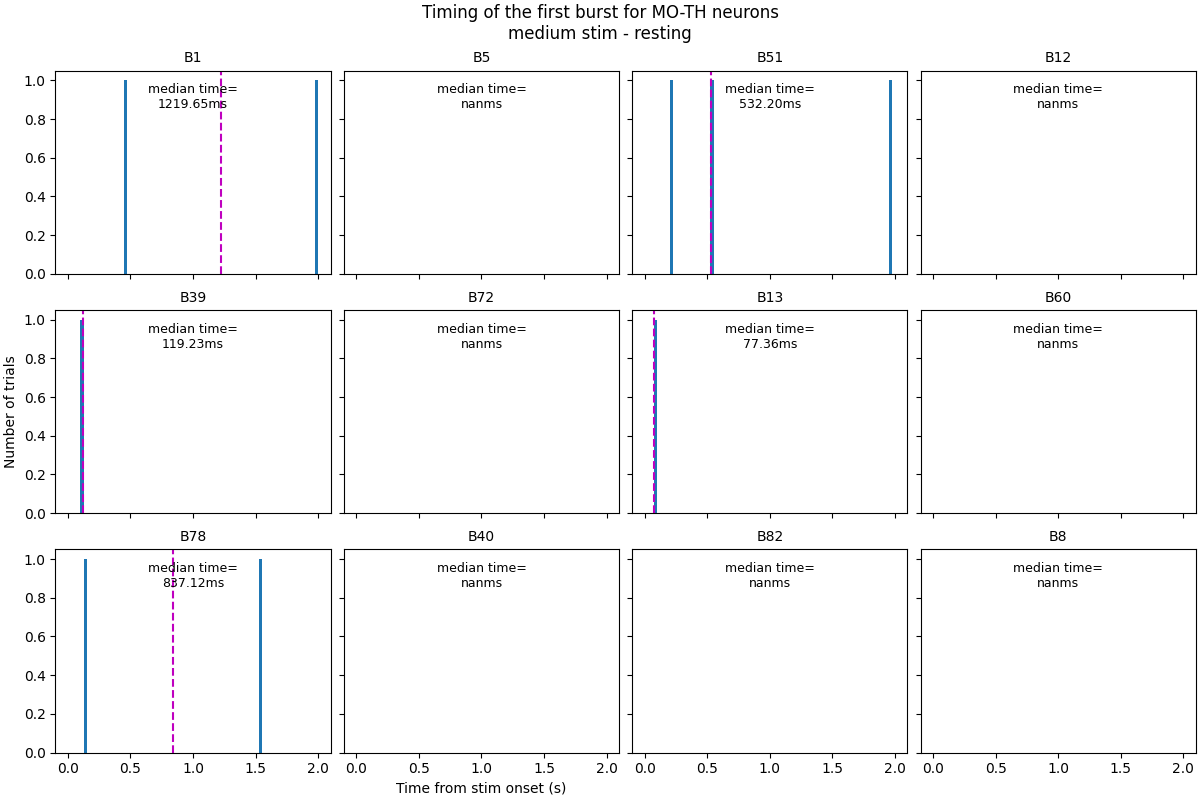

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [66]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'
unit_ids = reg_unit_info[regi]['unit_id'].values
bbbins = np.arange(0.0, 2.025, 0.025)

events = all_event_inds[pstim][pstate]
fig, axs = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True, constrained_layout=True)

unit_selection = np.random.choice(unit_ids, 12, replace=False)
for ax, uid in zip(axs.flatten(), unit_selection):
    first_bursts = []
    for jj in range(len(events)):
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        postb = np.nonzero(uburstsi >= 0.0)[0]
        if len(postb) > 0:
            first_bursts.append(uburstsi[postb[0]])
    ax.hist(first_bursts, bbbins)
    ax.axvline(np.median(first_bursts), color='m', linestyle='dashed')
    ax.annotate(
        'median time=\n{:.2f}ms'.format(np.median(first_bursts)*1E3), xy=(0.5, 0.8), xycoords='axes fraction',
        fontsize=9, ha='center', va='bottom'
    )
    ax.set_title(uid)
    
axs[2,1].set_xlabel('Time from stim onset (s)')
axs[1,0].set_ylabel('Number of trials')
plt.suptitle('Timing of the first burst for {} neurons\n{} stim - {}'.format(regi, pstim, pstate))

## Save ##
figname = 'firstbursttime_examples_{}-{}_{}-{}.png'.format(mouse_num, group, pstim, pstate)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


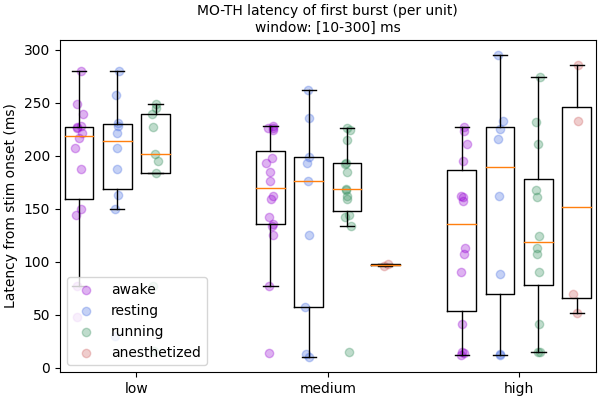

In [25]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
test_window = [0.01, 0.3] # [0.15, 0.3]
regi = 'MO-TH'
total_units = len(reg_unit_info[regi])
barlocs = np.arange((len(state_colors) + 1) * len(current_levels)).reshape((len(current_levels), (len(state_colors) + 1)))

for aa, (leveli, states_event_times) in enumerate(all_event_inds.items()):
    scatlegend = []
    for bb, (statei, einds) in enumerate(states_event_times.items()):
        first_burst_times = []
        for ii, unitrow in reg_unit_info[regi].iterrows():
            uid = unitrow.unit_id
            first_bursts = []
            for jj in range(len(einds)):
                uburstsi = np.array(unit_event_bursts[leveli][statei][uid]['times'][jj])
                counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    first_bursts.append(uburstsi[counts[0]])
            if len(first_bursts) > 0:
                first_burst_times.append(np.median(first_bursts) * 1E3)
        
        ax.boxplot(first_burst_times, positions=[barlocs[aa, bb]], widths=[0.75], showfliers=False)
        xs = np.random.normal(barlocs[aa, bb], 0.05, len(first_burst_times))
        dots = ax.scatter(xs, first_burst_times, c=state_colors[statei], alpha=0.3, label=statei)
        scatlegend.append(dots)
        
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(current_levels)
ax.set_ylabel('Latency from stim onset (ms)')
ax.set_title('{} latency of first burst (per unit)\nwindow: [{}-{}] ms'.format(
    regi, int(test_window[0]*1E3), int(test_window[1]*1E3)))
ax.legend(handles=scatlegend)

## Save ##
figname = 'firstburstlatency_{}-{}_{:d}-{:d}ms.png'.format(mouse_num, group, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Trial-by-trial comparison of ERP magnitude/duration and fraction of TH pop with burst

<IPython.core.display.Javascript object>


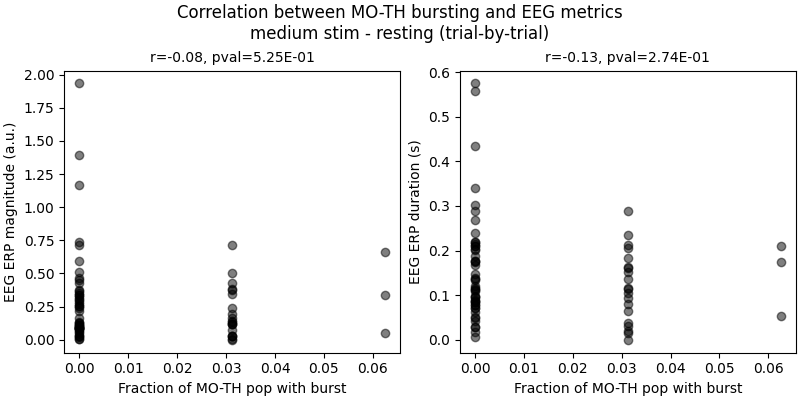

In [67]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'
test_window = [0.075, 0.3]
zlim = 3

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1][:, mdata['good_chs'], :]
einds = all_event_inds[pstim][pstate]

EEGmag = np.zeros(len(einds), dtype=float)
EEGdur = np.zeros(len(einds), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    gfpow = np.std(eegtraces[:, :, jj], axis=1)
    zgfpow = (gfpow - np.mean(gfpow[eegtime < 0])) / np.std(gfpow[eegtime < 0])
    EEGdur[jj] = np.sum(zgfpow[eegtime > 0] > zlim) / mdata['exp'].ephys_params['EEG']['sample_rate']
    zerp = np.where((zgfpow[eegtime > 0] - zlim) >= 0, (zgfpow[eegtime > 0] - zlim), 0.)
    EEGmag[jj] = integrate.simps(zerp, eegtime[eegtime > 0], axis=0, even='last')
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, constrained_layout=True)
## EEG magnitude ##
axs[0].scatter(pop_fraction, EEGmag, c='k', alpha=0.5)
magres = stats.linregress(pop_fraction, EEGmag)
axs[0].set_xlabel('Fraction of {} pop with burst'.format(regi))
axs[0].set_ylabel('EEG ERP magnitude (a.u.)')
axs[0].set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))

## EEG duration ##
axs[1].scatter(pop_fraction, EEGdur, c='k', alpha=0.5)
durres = stats.linregress(pop_fraction, EEGdur)
axs[1].set_xlabel('Fraction of {} pop with burst'.format(regi))
axs[1].set_ylabel('EEG ERP duration (s)')
axs[1].set_title('r={:.2f}, pval={:.2E}'.format(durres.rvalue, durres.pvalue))

plt.suptitle('Correlation between {} bursting and EEG metrics\n{} stim - {} (trial-by-trial)'.format(regi, pstim, pstate))

## Save ##
figname = 'corr_EEGtoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Trial by trial comparison of 2nd peak magnitude and number of bursting neurons

In [69]:
GOOD_CHS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 14, 15, 16, 17, 18, 19,
       20, 21, 23, 24, 25, 26, 27, 28, 29])

Plot a single channel

<IPython.core.display.Javascript object>


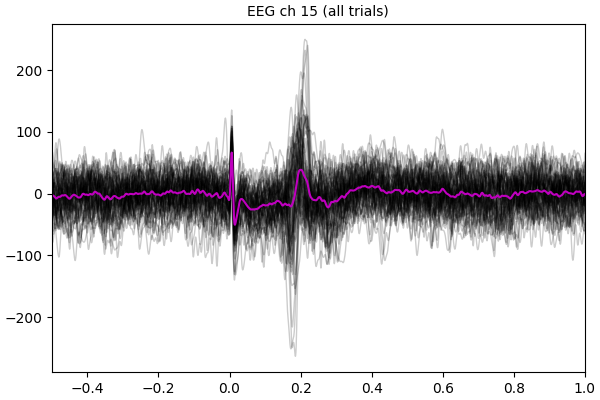

Text(0.5, 1.0, 'EEG ch 15 (all trials)')

In [68]:
pchan = 15
pstim = 'medium'
pstate = 'resting'
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1][:, pchan, :]

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.plot(eegtime, eegtraces, color='k', linewidth=1, alpha=0.2)
ax.plot(eegtime, np.mean(eegtraces, axis=1), color='m', linewidth=1.5)
ax.set_xlim(-0.5, 1.0)
ax.set_title('EEG ch {} (all trials)'.format(pchan))

Plot the global field power

<IPython.core.display.Javascript object>


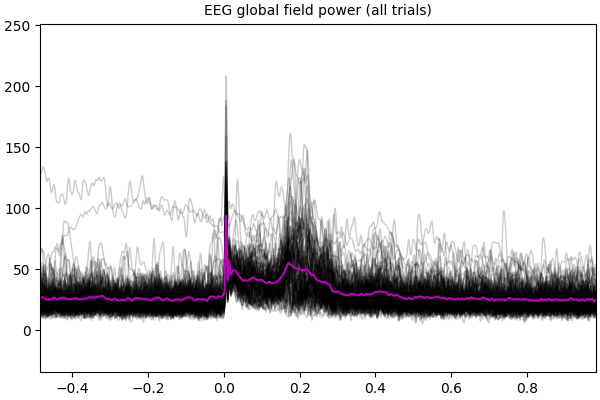

Text(0.5, 1.0, 'EEG global field power (all trials)')

In [70]:
pstim = 'medium'
pstate = 'awake'
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = np.std(EEG_traces[pstim][pstate][1][:, GOOD_CHS, :], axis=1)

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.plot(eegtime, eegtraces, color='k', linewidth=1, alpha=0.2)
ax.plot(eegtime, np.mean(eegtraces, axis=1), color='m', linewidth=1.5)
ax.set_xlim(-0.5, 1.0)
ax.set_title('EEG global field power (all trials)')

Plot the pop firing rate

<IPython.core.display.Javascript object>


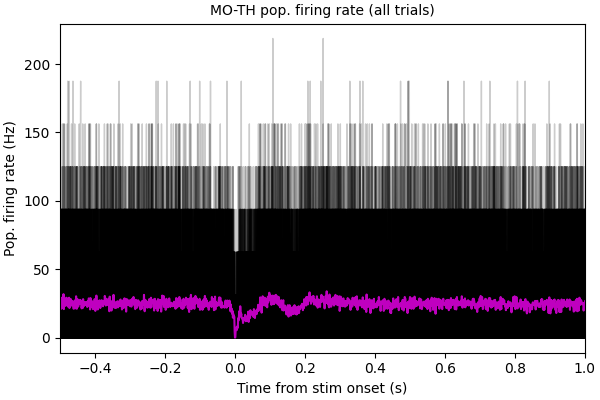

Text(0, 0.5, 'Pop. firing rate (Hz)')

In [71]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO-TH'

popfr_trials = np.zeros((len(timex), len(pop_event_spikes[pstim][pstate][regi])), dtype=float)
for tri, popevspikes in enumerate(pop_event_spikes[pstim][pstate][regi]):
    evspcounts, bedges = np.histogram(popevspikes, bins)
    popfr_trials[:, tri] = evspcounts / (time_bin * len(reg_unit_info[regi]))

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.plot(timex, popfr_trials, color='k', linewidth=1, alpha=0.2)
ax.plot(timex, np.mean(popfr_trials, axis=1), color='m', linewidth=1.5)
ax.set_xlim(-0.5, 1.0)
ax.set_title('{} pop. firing rate (all trials)'.format(regi))
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. firing rate (Hz)')

Plot the pop spike density function

<IPython.core.display.Javascript object>


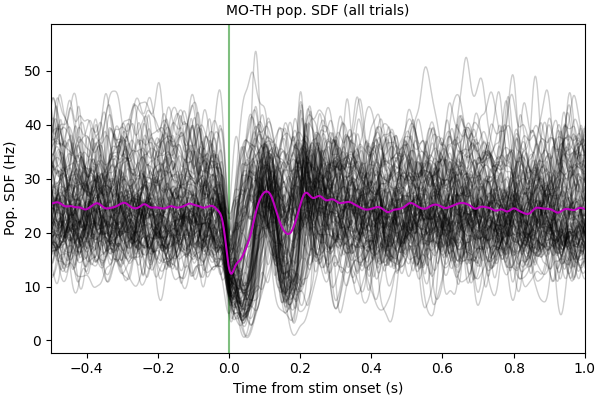

Text(0, 0.5, 'Pop. SDF (Hz)')

In [73]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO-TH'
sdf_tb = 0.001
sdf_sigma = 10
sdfbins = np.arange(event_window[0], event_window[1] + sdf_tb, sdf_tb)
sdftimex = sdfbins[:-1] + sdf_tb/2

popsdf_trials = np.zeros((len(sdftimex), len(pop_event_spikes[pstim][pstate][regi])), dtype=float)
for tri, popevspikes in enumerate(pop_event_spikes[pstim][pstate][regi]):
    evspcounts, bedges = np.histogram(popevspikes, sdfbins)
    popsdf_trials[:, tri] = (
        ndimage.gaussian_filter(evspcounts, sigma=sdf_sigma, output=float) / (sdf_tb * len(reg_unit_info[regi]))
    )

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.5)
ax.plot(sdftimex, popsdf_trials, color='k', linewidth=1, alpha=0.2)
ax.plot(sdftimex, np.mean(popsdf_trials, axis=1), color='m', linewidth=1.5)
ax.set_xlim(-0.5, 1.0)
ax.set_title('{} pop. SDF (all trials)'.format(regi))
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Pop. SDF (Hz)')

Correlate 2nd peak in one ch with number of bursting TH units per trial

<IPython.core.display.Javascript object>


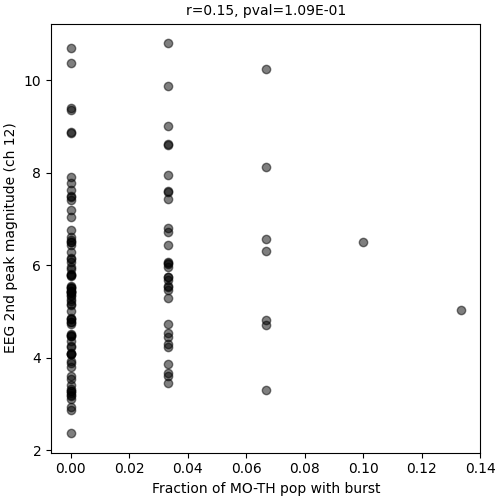

In [31]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO-TH'
test_window = [0.075, 0.3]
zlim = 3
EEGch = 12

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1][:, EEGch, :]
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGmag = np.zeros(len(einds), dtype=float)
blmag = np.zeros(len(einds), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    blmag[jj] = integrate.simps(np.abs(eegtraces[blinds, jj]), eegtime[blinds], axis=0, even='last')
    EEGmag[jj] = integrate.simps(np.abs(eegtraces[testinds, jj]), eegtime[testinds], axis=0, even='last')
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
## EEG magnitude ##
emag = EEGmag #(EEGmag - np.mean(blmag)) / np.std(blmag)
ax.scatter(pop_fraction, emag, c='k', alpha=0.5)
magres = stats.linregress(pop_fraction, emag)
ax.set_xlabel('Fraction of {} pop with burst'.format(regi))
ax.set_ylabel('EEG 2nd peak magnitude (ch {:d})'.format(EEGch))
ax.set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 50])

## Save ##
figname = 'corr_{:d}EEG2ndpeaktoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    EEGch, mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Correlate 2nd peak in GFP with number of bursting TH units per trial

<IPython.core.display.Javascript object>


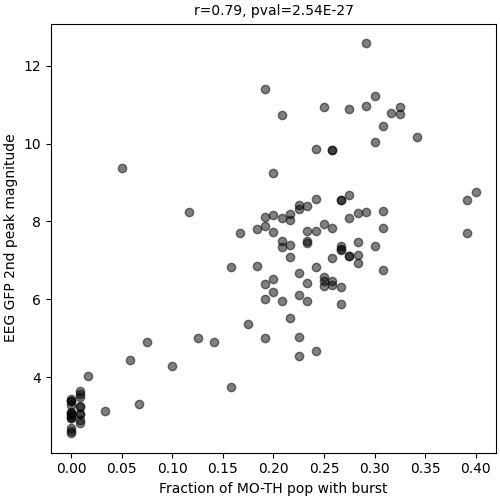

In [56]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO-TH'
test_window = [0.15, 0.3]
zlim = 3

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eeg_gpf = np.std(EEG_traces[pstim][pstate][1][:, GOOD_CHS, :], axis=1)
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGmag = np.zeros(len(einds), dtype=float)
blmag = np.zeros(len(einds), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    blmag[jj] = integrate.simps(np.abs(eeg_gpf[blinds, jj]), eegtime[blinds], axis=0, even='last')
    EEGmag[jj] = integrate.simps(eeg_gpf[testinds, jj], eegtime[testinds], axis=0, even='last')
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
## EEG magnitude ##
emag = EEGmag #(EEGmag - np.mean(blmag)) / np.std(blmag)
ax.scatter(pop_fraction, emag, c='k', alpha=0.5)
magres = stats.linregress(pop_fraction, emag)
ax.set_xlabel('Fraction of {} pop with burst'.format(regi))
ax.set_ylabel('EEG GFP 2nd peak magnitude')
ax.set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 50])

## Save ##
figname = 'corr_GFP2ndpeaktoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Correlate ERP GFP duration with number of bursting TH units per trial

<IPython.core.display.Javascript object>


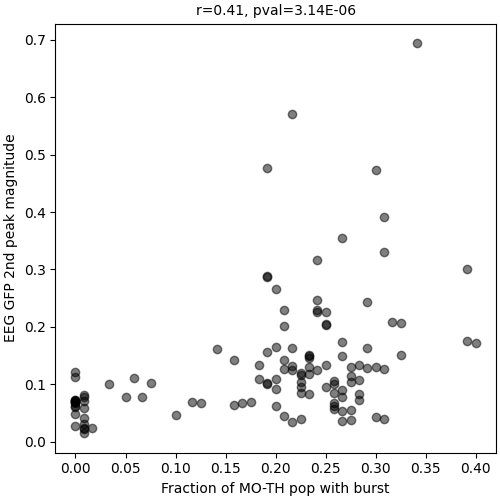

In [53]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO-TH'
test_window = [0.15, 0.3]
zlim = 3

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eeg_gfp = np.std(EEG_traces[pstim][pstate][1][:, GOOD_CHS, :], axis=1)
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGdur = np.zeros(len(einds), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    zgfpow = (eeg_gfp[:,jj] - np.mean(eeg_gfp[:,jj][eegtime < 0])) / np.std(eeg_gfp[:,jj][eegtime < 0])
    EEGdur[jj] = np.sum(zgfpow[eegtime > 0] > zlim) / mdata['exp'].ephys_params['EEG']['sample_rate']
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
## EEG magnitude ##
emag = EEGdur #(EEGdur - np.mean(blmag)) / np.std(blmag)
ax.scatter(pop_fraction, emag, c='k', alpha=0.5)
magres = stats.linregress(pop_fraction, emag)
ax.set_xlabel('Fraction of {} pop with burst'.format(regi))
ax.set_ylabel('EEG GFP 2nd peak magnitude')
ax.set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 50])

## Save ##
figname = 'corr_GFP2ndpeaktoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Correlate 2nd peak in GFP with pop SDF

<IPython.core.display.Javascript object>


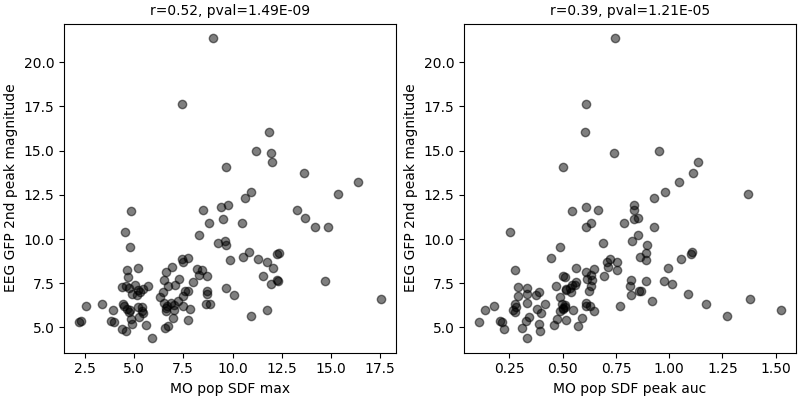

In [32]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO'
test_window = [0.075, 0.3]
## SDF params ##
sdf_tb = 0.001
sdf_sigma = 10
sdfbins = np.arange(event_window[0], event_window[1] + sdf_tb, sdf_tb)
sdftimex = sdfbins[:-1] + sdf_tb/2

t_sdf_units = len(reg_unit_info[regi])
sdf_tinds = np.nonzero((sdftimex >= test_window[0]) & (sdftimex <= test_window[1]))[0]

eegtime = EEG_traces[pstim][pstate][0]
eeg_gpf = np.std(EEG_traces[pstim][pstate][1][:, GOOD_CHS, :], axis=1)
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGmag = np.zeros(len(einds), dtype=float)
blmag = np.zeros(len(einds), dtype=float)
popsdf_max = np.zeros(len(einds), dtype=float)
sdf_auc = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    blmag[jj] = integrate.simps(eeg_gpf[blinds, jj], eegtime[blinds], axis=0, even='last')
    EEGmag[jj] = integrate.simps(eeg_gpf[testinds, jj], eegtime[testinds], axis=0, even='last')
    
    ## Get pop SDF peak ##
    evspcounts, bedges = np.histogram(pop_event_spikes[pstim][pstate][regi][jj], sdfbins)
    trialsdf = ndimage.gaussian_filter(evspcounts, sigma=sdf_sigma, output=float) / (sdf_tb * t_sdf_units)
    popsdf_max[jj] = np.max(trialsdf[sdf_tinds])
    sdf_auc[jj] = integrate.simps(trialsdf[sdf_tinds], sdftimex[sdf_tinds], axis=0, even='last')
    
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
## EEG magnitude ##
emag = EEGmag #(EEGmag - np.mean(blmag)) / np.std(blmag)
axs[0].scatter(popsdf_max, emag, c='k', alpha=0.5)
magres = stats.linregress(popsdf_max, emag)
axs[0].set_xlabel('{} pop SDF max'.format(regi))
axs[0].set_ylabel('EEG GFP 2nd peak magnitude')
axs[0].set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 50])

axs[1].scatter(sdf_auc, emag, c='k', alpha=0.5)
magresb = stats.linregress(sdf_auc, emag)
axs[1].set_xlabel('{} pop SDF peak auc'.format(regi))
axs[1].set_ylabel('EEG GFP 2nd peak magnitude')
axs[1].set_title('r={:.2f}, pval={:.2E}'.format(magresb.rvalue, magresb.pvalue))

## Save ##
figname = 'corr_GFP2ndpeak_to_{}burst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    regi, mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


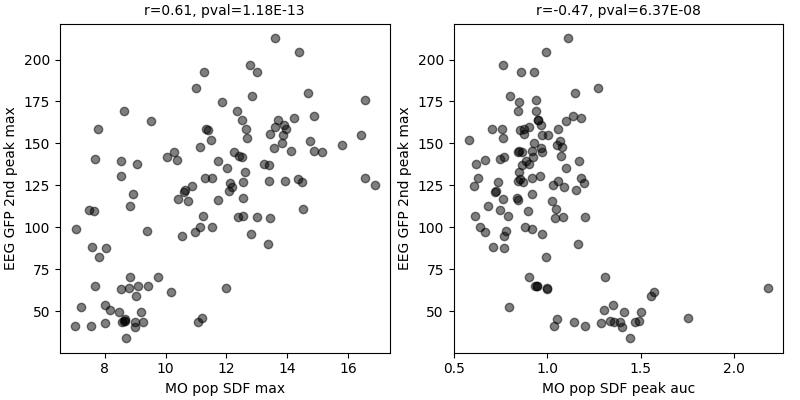

In [61]:
pstim = 'medium'
pstate = 'awake'
regi = 'MO'
test_window = [0.075, 0.3]
## SDF params ##
sdf_tb = 0.001
sdf_sigma = 10
sdfbins = np.arange(event_window[0], event_window[1] + sdf_tb, sdf_tb)
sdftimex = sdfbins[:-1] + sdf_tb/2

t_sdf_units = len(reg_unit_info[regi])
sdf_tinds = np.nonzero((sdftimex >= test_window[0]) & (sdftimex <= test_window[1]))[0]

eegtime = EEG_traces[pstim][pstate][0]
eeg_gpf = np.std(EEG_traces[pstim][pstate][1][:, GOOD_CHS, :], axis=1)
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGmag = np.zeros(len(einds), dtype=float)
popsdf_max = np.zeros(len(einds), dtype=float)
sdf_auc = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    EEGmag[jj] = np.max(eeg_gpf[testinds, jj])
    
    ## Get pop SDF peak ##
    evspcounts, bedges = np.histogram(pop_event_spikes[pstim][pstate][regi][jj], sdfbins)
    trialsdf = ndimage.gaussian_filter(evspcounts, sigma=sdf_sigma, output=float) / (sdf_tb * t_sdf_units)
    popsdf_max[jj] = np.max(trialsdf[sdf_tinds])
    sdf_auc[jj] = integrate.simps(trialsdf[sdf_tinds], sdftimex[sdf_tinds], axis=0, even='last')
    
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
## EEG magnitude ##
emag = EEGmag #(EEGmag - np.mean(blmag)) / np.std(blmag)
axs[0].scatter(popsdf_max, emag, c='k', alpha=0.5)
magres = stats.linregress(popsdf_max, emag)
axs[0].set_xlabel('{} pop SDF max'.format(regi))
axs[0].set_ylabel('EEG GFP 2nd peak max')
axs[0].set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 50])

axs[1].scatter(sdf_auc, emag, c='k', alpha=0.5)
magresb = stats.linregress(sdf_auc, emag)
axs[1].set_xlabel('{} pop SDF peak auc'.format(regi))
axs[1].set_ylabel('EEG GFP 2nd peak max')
axs[1].set_title('r={:.2f}, pval={:.2E}'.format(magresb.rvalue, magresb.pvalue))

## Save ##
figname = 'corr_GFP2ndpeak_to_{}burst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    regi, mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

Correlate cortical pop. FR (of stim area) with number of bursting TH units per trial

In [52]:
# %%time
stim_area

'MO'

<IPython.core.display.Javascript object>


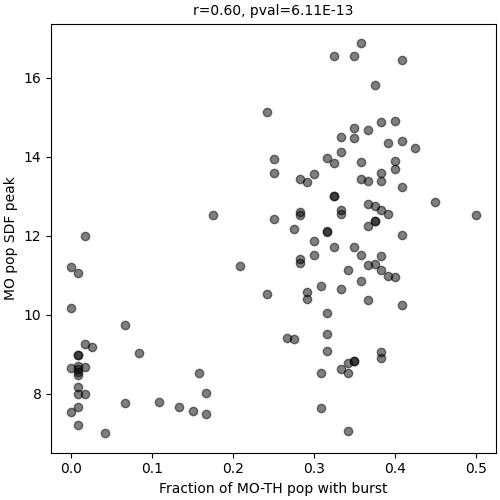

In [55]:
pstim = 'medium'
pstate = 'awake'
popfr_regi = 'MO'
burst_regi = 'MO-TH'
test_window = [0.075, 0.3]
## SDF params ##
sdf_tb = 0.001
sdf_sigma = 10
sdfbins = np.arange(event_window[0], event_window[1] + sdf_tb, sdf_tb)
sdftimex = sdfbins[:-1] + sdf_tb/2

t_sdf_units = len(reg_unit_info[popfr_regi])
t_burst_units = len(reg_unit_info[burst_regi])

einds = all_event_inds[pstim][pstate]
sdf_tinds = np.nonzero((sdftimex >= test_window[0]) & (sdftimex <= test_window[1]))[0]
popsdf_max = np.zeros(len(einds), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get pop SDF peak ##
    evspcounts, bedges = np.histogram(pop_event_spikes[pstim][pstate][popfr_regi][jj], sdfbins)
    trialsdf = ndimage.gaussian_filter(evspcounts, sigma=sdf_sigma, output=float) / (sdf_tb * t_sdf_units)
    popsdf_max[jj] = np.max(trialsdf[sdf_tinds])
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[burst_regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / t_burst_units
    
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.scatter(pop_fraction, popsdf_max, c='k', alpha=0.5)
magres = stats.linregress(pop_fraction, popsdf_max)
ax.set_xlabel('Fraction of {} pop with burst'.format(burst_regi))
ax.set_ylabel('{} pop SDF peak'.format(popfr_regi))
ax.set_title('r={:.2f}, pval={:.2E}'.format(magres.rvalue, magres.pvalue))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 25])

## Save ##
figname = 'corr_{}sdf_to_{}burst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    popfr_regi, burst_regi, mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Apply test to all electrodes

In [38]:
pstim = 'medium'
pstate = 'resting'
regi = 'MO-TH'
test_window = [0.075, 0.3]
zlim = 3

total_units = len(reg_unit_info[regi])
eegtime = EEG_traces[pstim][pstate][0]
eegtraces = EEG_traces[pstim][pstate][1]
einds = all_event_inds[pstim][pstate]

testinds = np.nonzero((eegtime >= test_window[0]) & (eegtime <= test_window[1]))[0]
blinds = np.nonzero((eegtime >= -test_window[1]) & (eegtime <= -test_window[0]))[0]

EEGmag = np.zeros((eegtraces.shape[1], len(einds)), dtype=float)
blmag = np.zeros((eegtraces.shape[1], len(einds)), dtype=float)
pop_fraction = np.zeros(len(einds), dtype=float)
for jj in range(len(einds)):
    ## Get EEG metrics ##
    blmag[:, jj] = integrate.simps(np.abs(eegtraces[blinds, :, jj]), eegtime[blinds], axis=0, even='last')
    EEGmag[:, jj] = integrate.simps(np.abs(eegtraces[testinds, :, jj]), eegtime[testinds], axis=0, even='last')
    
    ## Get pop counts ##
    uc = 0
    for ii, unitrow in reg_unit_info[regi].iterrows():
        uid = unitrow.unit_id
        uburstsi = np.array(unit_event_bursts[pstim][pstate][uid]['times'][jj])
        counts = np.nonzero((uburstsi >= test_window[0]) & (uburstsi <= test_window[1]))[0]
        if len(counts) > 0:
            uc += 1
    pop_fraction[jj] = uc / total_units
    
Prs, Pps = np.zeros((eegtraces.shape[1]), dtype=float), np.zeros((eegtraces.shape[1]), dtype=float)
Sprs, Spps = np.zeros((eegtraces.shape[1]), dtype=float), np.zeros((eegtraces.shape[1]), dtype=float)
for ii in range(eegtraces.shape[1]):
    Prs[ii], Pps[ii] = stats.pearsonr(pop_fraction, EEGmag[ii,:])
    Sprs[ii], Spps[ii] = stats.spearmanr(pop_fraction, EEGmag[ii,:])

<IPython.core.display.Javascript object>


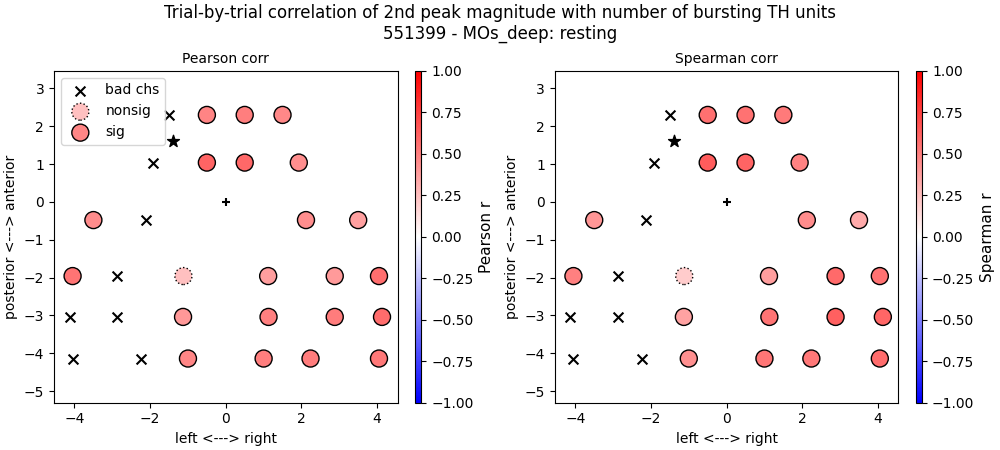

In [39]:
alpha = 0.01
fig, axs = plt.subplots(1, 2, figsize=(10,4.5), constrained_layout=True)
## Pearson ##
goodchmask = np.array([True if x in GOOD_CHS else False for x in range(eegtraces.shape[1])])
badchmask = ~goodchmask
sigmask = (Pps < alpha) * goodchmask
nonsigmask = (Pps >= alpha) * goodchmask
# plot bad chs #
axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=Prs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axs[0].scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=Prs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axs[0].set_xlabel('left <---> right')
axs[0].set_ylabel('posterior <---> anterior')
axs[0].scatter(0, 0, marker='+', color='k')
axs[0].scatter(-1.4, 1.6, marker='*', color='k', s=80)
axs[0].axis('equal')
axs[0].legend(loc='upper left')
axs[0].set_title('Pearson corr')
cb = fig.colorbar(rcb, ax=axs[0], aspect=50)
cb.set_label('Pearson r', fontsize=11)

## Spearman ##
sigmask = (Spps < alpha) * goodchmask
nonsigmask = (Spps >= alpha) * goodchmask
# plot bad chs #
axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][badchmask], EEGexp.EEG_channel_coordinates['AP'][badchmask],
    c='k', s=50, marker='x', label='bad chs'
)
# plot good chs, non significant #
axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][nonsigmask], EEGexp.EEG_channel_coordinates['AP'][nonsigmask],
    c=Sprs[nonsigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', linestyle='dotted', label='nonsig'
)
# plot good chs, significant #
rcb = axs[1].scatter(
    EEGexp.EEG_channel_coordinates['ML'][sigmask], EEGexp.EEG_channel_coordinates['AP'][sigmask],
    c=Sprs[sigmask], s=150, cmap='bwr', vmin=-1, vmax=1, edgecolor='k', label='sig'
)
axs[1].set_xlabel('left <---> right')
axs[1].set_ylabel('posterior <---> anterior')
axs[1].scatter(0, 0, marker='+', color='k')
axs[1].scatter(-1.4, 1.6, marker='*', color='k', s=80)
axs[1].axis('equal')
axs[1].set_title('Spearman corr')
cb = fig.colorbar(rcb, ax=axs[1], aspect=50)
cb.set_label('Spearman r', fontsize=11)

plt.suptitle('Trial-by-trial correlation of 2nd peak magnitude with number of bursting TH units\n{} - {}: {}'.format(
    mouse_num, group, pstate
))

## Save ##
figname = 'corr_allEEGs2ndpeaktoTHburst_{}-{}_{}-{}_{:d}-{:d}ms.png'.format(
    mouse_num, group, pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Make a population raster plot of MO and MO-TH for an example trial

<IPython.core.display.Javascript object>


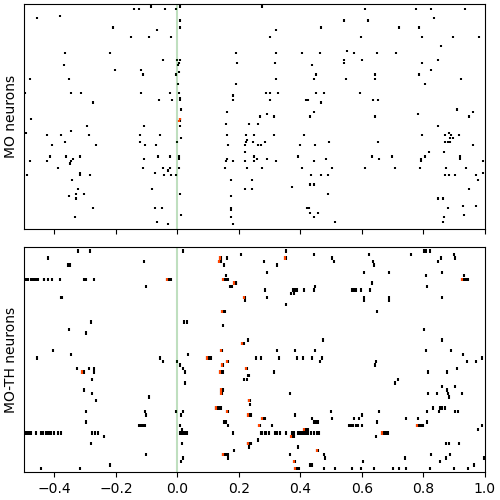

(-0.5, 1.0)

In [107]:
pstim = 'medium'
pstate = 'resting'
regis = {'MO': 'RS', 'MO-TH': None}
triali = 2 # 2, 10, 11

fig, axs = plt.subplots(len(regis), figsize=(5,5), sharex=True, constrained_layout=True)
for ax, (regi, cellty) in zip(axs.flatten(), regis.items()):
    if cellty:
        unit_ids = reg_unit_info[regi]['unit_id'][reg_unit_info[regi]['cell_type'] == cellty].values
    else:
        unit_ids = reg_unit_info[regi]['unit_id'].values
    ax.axvline(0, color='g', alpha=0.25)
    for indi, uid in enumerate(unit_ids):
        ax.eventplot(
            [unit_event_spikes[pstim][pstate][uid][triali]], lineoffsets=indi, linelengths=0.95, color='black')
        ax.eventplot(
            [unit_event_bursts[pstim][pstate][uid]['times'][triali]], lineoffsets=indi, linelengths=0.95, color='orangered')
    ax.set_ylabel('{} neurons'.format(regi))
    ax.set_yticks([])
    ax.set_ylim([-1, indi+1])
axs[1].set_xlim([-0.5, 1.0])

#### Make pop SDF plots

<IPython.core.display.Javascript object>


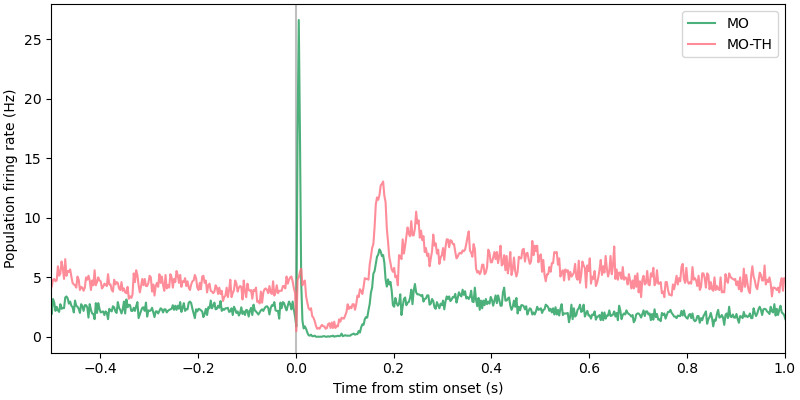

In [122]:
pstim = 'medium'
pstate = 'resting'
regis = {'MO': 'RS', 'MO-TH': None}

time_bin = 0.0025
bins = np.arange(-2.0, 2.0 + time_bin, time_bin)
timex = bins[:-1] + time_bin / 2

pop_firing_rates = {}
for regi, cellty in regis.items():
    if cellty:
        unit_ids = reg_unit_info[regi]['unit_id'][reg_unit_info[regi]['cell_type'] == cellty].values
    else:
        unit_ids = reg_unit_info[regi]['unit_id'].values
    
    unit_firing_rates = np.zeros((len(unit_ids), len(timex)), dtype=float) * np.nan
    for indi, uid in enumerate(unit_ids):
        unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes[pstim][pstate][uid]), bins)
        unit_firing_rates[indi, :] = unit_event_counts / (time_bin * len(unit_event_spikes[pstim][pstate][uid]))
        
    pop_firing_rates[regi] = np.nanmean(unit_firing_rates, axis=0)
    
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.axvline(0, color='k', alpha=0.25)
for regi, popFR in pop_firing_rates.items():
    blmean = np.mean(popFR[timex < 0])
    blstd = np.std(popFR[timex < 0])
    ax.plot(timex, popFR, color=area_colors[regi], linewidth=1.5, alpha=0.8, label=regi)
#     ax.axhline(blmean + (2 * blstd), color=area_colors[regi], linestyle='dashed', alpha=0.8)
ax.set_ylabel('Population firing rate (Hz)')
ax.set_xlabel('Time from stim onset (s)')
ax.set_xlim([-0.5, 1.0])
ax.legend()

### Get list of significant units

In [139]:
test_window = [0.002, 0.025]
alpha = 0.05

all_sig_stats = []
for leveli, states_event_times in all_event_inds.items():
    for statei, einds in states_event_times.items():
        for regi, regdf in reg_unit_info.items():
            for ii, unitrow in regdf.iterrows():
                uid = unitrow.unit_id
                uspikesi = unit_event_spikes[leveli][statei][uid]
                pre_counts = np.zeros(len(einds), dtype=int)
                post_counts = np.zeros(len(einds), dtype=int)
                first_spikes = []
                for jj in range(len(einds)):
                    pre_counts[jj] = np.sum((uspikesi[jj] >= -test_window[1]) & (uspikesi[jj] <= -test_window[0]))
                    post_counts[jj] = np.sum((uspikesi[jj] >= test_window[0]) & (uspikesi[jj] <= test_window[1]))
                    early_spikes = np.nonzero((uspikesi[jj] >= test_window[0]) & (uspikesi[jj] <= test_window[1]))[0]
                    if len(early_spikes) > 0:
                        first_spikes.append(uspikesi[jj][early_spikes[0]])
                wstat, pval = stats.wilcoxon(x=post_counts, y=pre_counts, zero_method='zsplit')
                spcount = np.mean(post_counts) - np.mean(pre_counts)
                if len(first_spikes) > 0:
                    med_first_spike_time = np.median(first_spikes)
                else:
                    med_first_spike_time = np.nan
                all_sig_stats.append([uid, regi, leveli, statei, pval, int(pval < alpha), spcount, med_first_spike_time])
sigstatsdf = pd.DataFrame(all_sig_stats, columns=[
    'unit_id', 'parent', 'stim_level', 'state', 'pvalue', 'sig', 'spike_diff', 'median_first_spike'])

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [140]:
sigstatsdf.head()

,unit_id,parent,stim_level,state,pvalue,sig,spike_diff,median_first_spike
0,F718,MO,low,resting,1.000000,0,0.000000,NaN
1,F630,MO,low,resting,1.000000,0,0.000000,0.023497
2,F737,MO,low,resting,0.846687,0,0.009615,0.007675
3,F627,MO,low,resting,0.849473,0,0.009615,0.003582
4,F614,MO,low,resting,0.725734,0,-0.019231,0.010862


#### Fraction of units responding

In [141]:
barlocs = np.arange((len(state_colors) + 1) * len(reg_unit_info)).reshape((len(reg_unit_info), (len(state_colors) + 1)))
# print(barlocs)

<IPython.core.display.Javascript object>


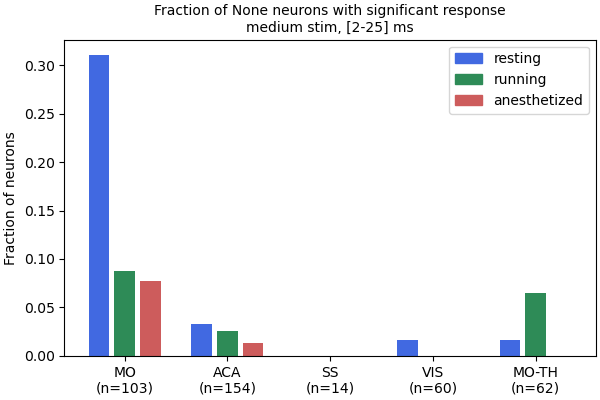

In [142]:
tstim = 'medium'

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
reg_labels = []
for ri, regi in enumerate(reg_unit_info.keys()):
    for si, statei in enumerate(unit_event_spikes[tstim].keys()):
        df = sigstatsdf[(sigstatsdf['parent'] == regi) & (sigstatsdf['stim_level'] == tstim) & (sigstatsdf['state'] == statei)]
        sig_evoked_units = df['sig'].values
        ax.bar(barlocs[ri, si], np.mean(sig_evoked_units), color=state_colors[statei])
        if si == 0:
            reg_labels.append('{}\n(n={:d})'.format(regi, len(sig_evoked_units)))
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(reg_labels)
ax.set_ylabel('Fraction of neurons')
ax.set_title('Fraction of {} neurons with significant response\n{} stim, [{:d}-{:d}] ms'.format(
    celltype, tstim, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Make a legend ##
mhandles = []
for statei, colori in state_colors.items():
    mhandles.append(Patch(color=colori, label=statei))
ax.legend(handles=mhandles)

#### Median first spike for significant neurons only

<IPython.core.display.Javascript object>


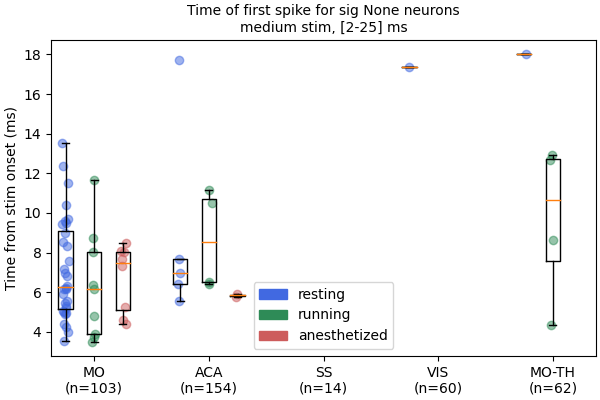

In [143]:
tstim = 'medium'

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
reg_labels = []
for ri, regi in enumerate(reg_unit_info.keys()):
    for si, statei in enumerate(unit_event_spikes[tstim].keys()):
        df = sigstatsdf[(sigstatsdf['parent'] == regi) & (sigstatsdf['stim_level'] == tstim) & (sigstatsdf['state'] == statei)]
        first_spikes = df['median_first_spike'].values[df['sig'].values.astype(bool)] * 1E3
        ax.boxplot(first_spikes, positions=[barlocs[ri, si]], widths=[0.5], showfliers=False)
        xs = np.random.normal(barlocs[ri, si], 0.05, len(first_spikes))
        ax.scatter(xs, first_spikes, c=state_colors[statei], alpha=0.5)
        if si == 0:
            reg_labels.append('{}\n(n={:d})'.format(regi, len(df)))
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(reg_labels)
ax.set_ylabel('Time from stim onset (ms)')
ax.set_title('Time of first spike for sig {} neurons\n{} stim, [{:d}-{:d}] ms'.format(
    celltype, tstim, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Make a legend ##
mhandles = []
for statei, colori in state_colors.items():
    mhandles.append(Patch(color=colori, label=statei))
ax.legend(handles=mhandles)

#### Median first spike for all neurons

<IPython.core.display.Javascript object>


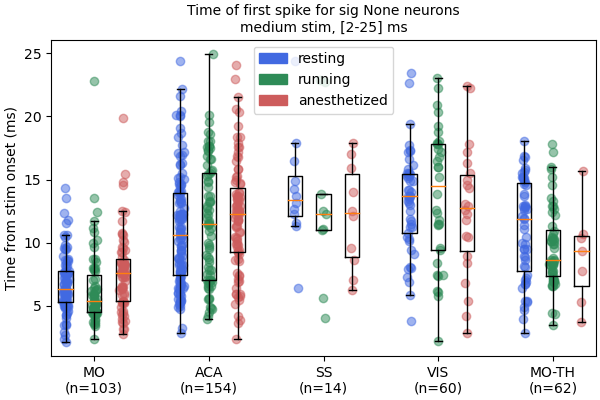

In [144]:
tstim = 'medium'

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
reg_labels = []
for ri, regi in enumerate(reg_unit_info.keys()):
    for si, statei in enumerate(unit_event_spikes[tstim].keys()):
        df = sigstatsdf[(sigstatsdf['parent'] == regi) & (sigstatsdf['stim_level'] == tstim) & (sigstatsdf['state'] == statei)]
        first_spikes = df['median_first_spike'].values * 1E3
        nanmask = np.isnan(first_spikes)
        ax.boxplot(first_spikes[~nanmask], positions=[barlocs[ri, si]], widths=[0.5], showfliers=False)
        xs = np.random.normal(barlocs[ri, si], 0.05, len(first_spikes))
        ax.scatter(xs, first_spikes, c=state_colors[statei], alpha=0.5)
        if si == 0:
            reg_labels.append('{}\n(n={:d})'.format(regi, len(df)))
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(reg_labels)
ax.set_ylabel('Time from stim onset (ms)')
ax.set_title('Time of first spike for sig {} neurons\n{} stim, [{:d}-{:d}] ms'.format(
    celltype, tstim, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Make a legend ##
mhandles = []
for statei, colori in state_colors.items():
    mhandles.append(Patch(color=colori, label=statei))
ax.legend(handles=mhandles)

In [137]:
nanmask = np.isnan(first_spikes)
print(first_spikes[~nanmask])

[41.35792009 22.21770075  3.70095864 25.09350455 10.66860481 15.66957303
 40.69520484  5.29093019 10.38739017]


### Test for significant activation in populations

### Probability of evoked response per trial based on population

This calculates the fraction of trials with a "significant" population response. A significant trial response is determined by comparing the pre/post spike counts for all neurons in the population. If the Wilcoxon signed-rank test returns a p-value less than alpha (0.05), it is considered a "significant" response to the trial. **I don't think this is working well.**

## Load example mouse with superficial and deep stim

In [20]:
## Parameters ##
celltype = 'RS'
time_bin = 0.005 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

test_window = [0.0, 0.6]
alpha = 0.05

In [21]:
example_mice = {
    'MOs_superficial': '571619',
    'MOs_deep': '571619',
}

all_subs_stats = []
for group, mouse_num in example_mice.items():
    print('{} - {}'.format(group, mouse_num))
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    mdata = multi_sub_dict[group][mouse_num]
    evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

    ## Load unit info ##
    fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
            all_unit_event_spikes = pickle.load(unit_file)
    else:
        print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
        continue

    ## Grab exp metadata from Zap_Zip-log_exp ##
    exp_meta = zzmetadata[(
        (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
        (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
    )].squeeze()
    currentstr = exp_meta['Current (uA)'].replace(' ','')
    currents_list = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            currents_list.append(char)

    ## Load stim log (includes running speed now) ##
    stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
    stim_log = stim_log.astype({'parameter': str})
    event_window = all_unit_event_spikes['event_window']
    # bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
    # timex = bins[:-1] + time_bin/2

    ## Get event inds ##
    all_event_inds = {}
    for leveli, parami in zip(current_levels, currents_list):
        all_event_inds[leveli] = {}
        for statei in test_states:
            sweeps = mdata['states'][statei]
            if not sweeps:
                continue
            if statei == 'awake':
                substates = ['resting', 'running']
                for substatei in substates:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][substatei] = np.concatenate(state_events)
            else:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)

    ## Loop through regions/units to get event-related spike times ##
    start = time.time()
    reg_unit_info = {}
    for region in areas_of_interest.keys():
        regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
        if len(regdf) > 8:
            reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)

    for leveli, states_event_times in all_event_inds.items():
        for statei, event_inds in states_event_times.items():
            for regi, regdf in reg_unit_info.items():
                stim_ctx = regi == stim_area
                sig_evoked_units = np.zeros(len(regdf), dtype=int)
                ## Get unit event spike times ##
                for ii, unitrow in regdf.iterrows():
                    pre_counts = np.zeros(len(event_inds), dtype=int)
                    post_counts = np.zeros(len(event_inds), dtype=int)
#                     first_spikes = []
                    for jj, eventi in enumerate(event_inds):
                        uspikesi = all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi]
                        pre_counts[jj] = np.sum((uspikesi >= -test_window[1]) & (uspikesi <= -test_window[0]))
                        post_counts[jj] = np.sum((uspikesi >= test_window[0]) & (uspikesi <= test_window[1]))
#                         early_spikes = np.nonzero((uspikesi >= test_window[0]) & (uspikesi <= test_window[1]))[0]
#                         if len(early_spikes) > 0:
#                             first_spikes.append(uspikesi[jj][early_spikes[0]])
                    wstat, pval = stats.wilcoxon(x=post_counts, y=pre_counts, zero_method='zsplit')
                    spcount = np.mean(post_counts) - np.mean(pre_counts)
#                     if len(first_spikes) > 0:
#                         med_first_spike_time = np.median(first_spikes)
#                     else:
#                         med_first_spike_time = np.nan
                    sig_evoked_units[ii] = pval < alpha
                all_subs_stats.append([
                    group, mouse_num, stim_area, stim_depth, regi, stim_ctx, leveli, statei, np.mean(sig_evoked_units)
                ])

    del stim_log, all_unit_event_spikes
    end = time.time()
    print('  Time to get event spike times: {:.2f} s\n'.format(end-start))

## Create stats dataframe ##
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'stim_level', 'state', 'fr_resp'
])

MOs_superficial - 571619
  Time to get event spike times: 10.91 s

MOs_deep - 571619
  Time to get event spike times: 10.80 s



In [54]:
all_subs_stats_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,stim_level,state,fr_resp
0,MOs_superficial,571619,MO,superficial,MO,True,low,resting,0.031579
1,MOs_superficial,571619,MO,superficial,ACA,False,low,resting,0.014493
2,MOs_superficial,571619,MO,superficial,SS,False,low,resting,0.000000
3,MOs_superficial,571619,MO,superficial,VIS,False,low,resting,0.021277
4,MOs_superficial,571619,MO,superficial,MO-TH,False,low,resting,0.018868


### Make a plot comparing fraction responsive for MO and MO-TH in superficial vs. deep stim 

<IPython.core.display.Javascript object>


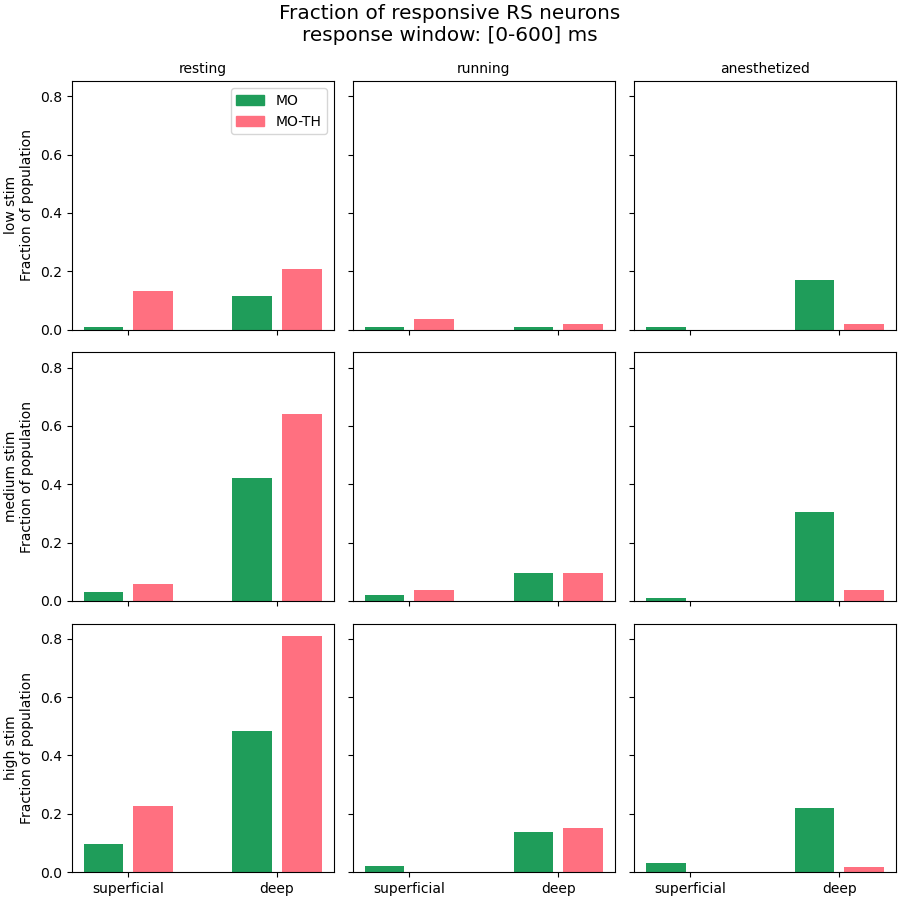

In [22]:
compare = ['superficial', 'deep']
plot_regions = ['MO', 'MO-TH']
barlocs = np.arange((len(plot_regions) + 1) * len(compare))
barlocs = barlocs.reshape((len(compare), (len(plot_regions) + 1)))

fig, axs = plt.subplots(
    len(current_levels), len(state_colors), figsize=(9, 9), sharex=True, sharey=True, constrained_layout=True)

for rowi, leveli in enumerate(current_levels):
    for coli, (statei, scolori) in enumerate(state_colors.items()):
        for ii, compi in enumerate(compare):
            for jj, regi in enumerate(plot_regions):
                fraction = all_subs_stats_df['fr_resp'][
                    (all_subs_stats_df['stim_level'] == leveli) & (all_subs_stats_df['state'] == statei) &
                    (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df['region'] == regi)
                ].values
                axs[rowi, coli].bar(barlocs[ii, jj], fraction, color=[area_colors[regi]])
        if rowi == 0:
            axs[rowi, coli].set_title(statei)
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\nFraction of population'.format(leveli))
axs[2,1].set_xticks(np.mean(barlocs[:,:-1], axis=1))
axs[2,1].set_xticklabels(compare)

## Make a legend ##
mhandles = []
for regi in plot_regions:
    mhandles.append(Patch(color=area_colors[regi], label=regi))
axs[0,0].legend(handles=mhandles)

plt.suptitle('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_571619_supvsdeep_{:d}-{:d}ms.png'.format(int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## All subjects

In [23]:
## Parameters ##
celltype = 'RS'
time_bin = 0.005 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

test_window = [0.0, 0.6]
alpha = 0.05

In [24]:
all_subs_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        # bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        # timex = bins[:-1] + time_bin/2

        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
                else:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)

        ## Loop through regions/units to get event-related spike times ##
        start = time.time()
        reg_unit_info = {}
        for region in areas_of_interest.keys():
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if len(regdf) > 8:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)

        for leveli, states_event_times in all_event_inds.items():
            for statei, event_inds in states_event_times.items():
                for regi, regdf in reg_unit_info.items():
                    stim_ctx = regi == stim_area
                    sig_evoked_units = np.zeros(len(regdf), dtype=int)
                    ## Get unit event spike times ##
                    for ii, unitrow in regdf.iterrows():
                        pre_counts = np.zeros(len(event_inds), dtype=int)
                        post_counts = np.zeros(len(event_inds), dtype=int)
                        for jj, eventi in enumerate(event_inds):
                            uspikesi = all_unit_event_spikes['event_spikes'][unitrow.unit_id][eventi]
                            pre_counts[jj] = np.sum((uspikesi >= -test_window[1]) & (uspikesi <= -test_window[0]))
                            post_counts[jj] = np.sum((uspikesi >= test_window[0]) & (uspikesi <= test_window[1]))
                        wstat, pval = stats.wilcoxon(x=post_counts, y=pre_counts, zero_method='zsplit')
                        spcount = np.mean(post_counts) - np.mean(pre_counts)
                        sig_evoked_units[ii] = pval < alpha
                    all_subs_stats.append([
                        group, mouse_num, stim_area, stim_depth, regi, stim_ctx, leveli, statei, np.mean(sig_evoked_units)
                    ])

        del stim_log, all_unit_event_spikes
        end = time.time()
        print('  Time to get event spike times: {:.2f} s'.format(end-start))
    print('')
## Create stats dataframe ##
all_subs_stats_df = pd.DataFrame(all_subs_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'stim_level', 'state', 'fr_resp'
])

MOs_superficial

 546655
  Time to get event spike times: 0.71 s
 575102
  Time to get event spike times: 3.57 s
 571619
  Time to get event spike times: 11.25 s

MOs_deep

 551399


C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


  Time to get event spike times: 8.56 s
 551397
  Time to get event spike times: 11.92 s
 569062
  Time to get event spike times: 18.61 s
 569068
  Time to get event spike times: 4.76 s
 569069
  Time to get event spike times: 6.46 s
 569064
  Time to get event spike times: 3.99 s
 569073
  Time to get event spike times: 7.73 s
 571619
  Time to get event spike times: 11.51 s

SSp_superficial

 571620
  Time to get event spike times: 8.99 s
 586466
  Time to get event spike times: 5.99 s
 590479
  Time to get event spike times: 9.95 s
 590480
  Time to get event spike times: 10.03 s

SSp_deep

 569073
  Time to get event spike times: 8.72 s
 569072
  Time to get event spike times: 16.78 s
 571620
  Time to get event spike times: 8.97 s
 586466
  Time to get event spike times: 5.64 s
 590479
  Time to get event spike times: 9.77 s
 590480
  Time to get event spike times: 10.05 s



In [25]:
all_subs_stats_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,stim_level,state,fr_resp
0,MOs_superficial,546655,MO,superficial,MO,True,low,resting,0.444444
1,MOs_superficial,546655,MO,superficial,MO,True,low,running,0.055556
2,MOs_superficial,546655,MO,superficial,MO,True,low,anesthetized,0.111111
3,MOs_superficial,546655,MO,superficial,MO,True,medium,resting,0.500000
4,MOs_superficial,546655,MO,superficial,MO,True,medium,running,0.222222


### Make a plot comparing fraction responsive for stim ctx and MO-TH in superficial vs. deep stim 

<IPython.core.display.Javascript object>


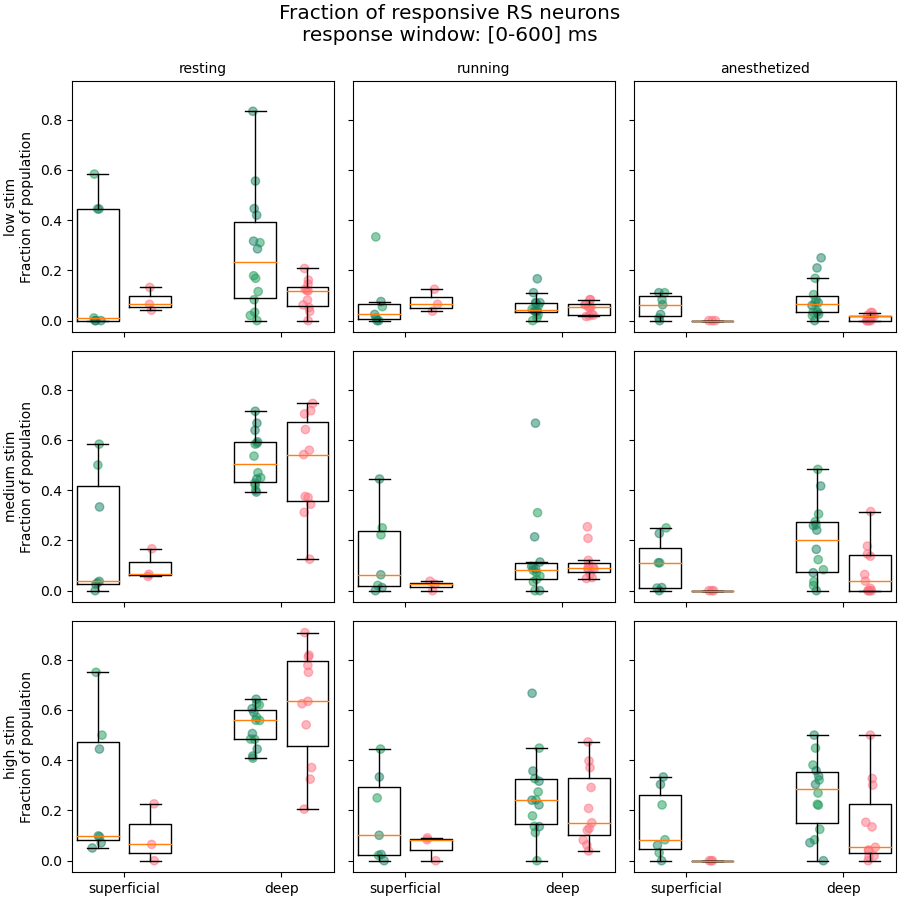

In [27]:
compare = ['superficial', 'deep']
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
barlocs = np.arange((len(plot_regions) + 1) * len(compare))
barlocs = barlocs.reshape((len(compare), (len(plot_regions) + 1)))

fig, axs = plt.subplots(
    len(current_levels), len(state_colors), figsize=(9, 9), sharex=True, sharey=True, constrained_layout=True)

for rowi, leveli in enumerate(current_levels):
    for coli, (statei, scolori) in enumerate(state_colors.items()):
        for ii, compi in enumerate(compare):
            for jj, (categ, spec) in enumerate(plot_regions.items()):
                df = all_subs_stats_df[
                    (all_subs_stats_df['stim_level'] == leveli) & (all_subs_stats_df['state'] == statei) &
                    (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
                ]
                fractions = df['fr_resp'].values
                sccolors = [area_colors[regi] for regi in df['region'].values]
                axs[rowi, coli].boxplot(fractions, positions=[barlocs[ii, jj]], widths=[0.8], showfliers=False)
                xs = np.random.normal(barlocs[ii, jj], 0.05, len(fractions))
                axs[rowi, coli].scatter(xs, fractions, c=sccolors, alpha=0.5)
                
#                 axs[rowi, coli].bar(barlocs[ii, jj], fraction, color=[area_colors[regi]])
        if rowi == 0:
            axs[rowi, coli].set_title(statei)
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\nFraction of population'.format(leveli))
axs[2,1].set_xticks(np.mean(barlocs[:,:-1], axis=1))
axs[2,1].set_xticklabels(compare)

## Make a legend ##
# mhandles = []
# for regi in plot_regions:
#     mhandles.append(Patch(color=area_colors[regi], label=regi))
# axs[0,0].legend(handles=mhandles)

plt.suptitle('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_all_supvsdeep_{:d}-{:d}ms.png'.format(int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


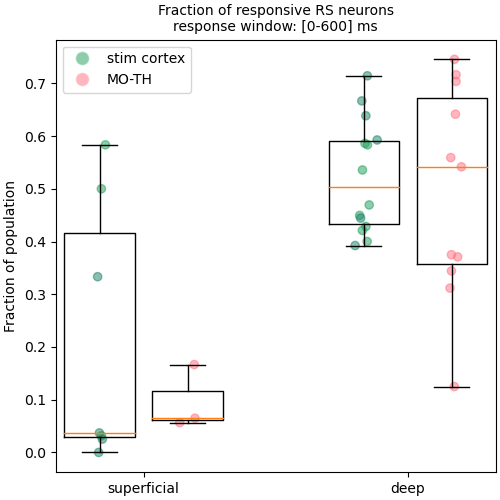

In [43]:
compare = ['superficial', 'deep']
plot_regions = {'stim_cortex': True, 'region': 'MO-TH'}
barlocs = np.arange((len(plot_regions) + 1) * len(compare)).reshape((len(compare), (len(plot_regions) + 1)))

pstim = 'medium'
pstate = 'resting'

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

for ii, compi in enumerate(compare):
    for jj, (categ, spec) in enumerate(plot_regions.items()):
        df = all_subs_stats_df[
            (all_subs_stats_df['stim_level'] == pstim) & (all_subs_stats_df['state'] == pstate) &
            (all_subs_stats_df['stim_depth'] == compi) & (all_subs_stats_df[categ] == spec)
        ]
        fractions = df['fr_resp'].values
        sccolors = [area_colors[regi] for regi in df['region'].values]
        ax.boxplot(fractions, positions=[barlocs[ii, jj]], widths=[0.8], showfliers=False)
        xs = np.random.normal(barlocs[ii, jj], 0.05, len(fractions))
        ax.scatter(xs, fractions, c=sccolors, alpha=0.5)
ax.set_ylabel('Fraction of population')
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(compare)

## Make a legend ##
mhandles = [
    Line2D([0], [0], marker='o', color='w', label='stim cortex', markerfacecolor=area_colors['MO'], markersize=10, alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='MO-TH', markerfacecolor=area_colors['MO-TH'], markersize=10, alpha=0.5),
]

ax.legend(handles=mhandles)

ax.set_title('Fraction of responsive {} neurons\nresponse window: [{:d}-{:d}] ms'.format(
    celltype, int(test_window[0]*1E3), int(test_window[1]*1E3)))

## Save ##
figname = 'FractionResponsive_all_supvsdeep_{}-{}_{:d}-{:d}ms.png'.format(
    pstim, pstate, int(test_window[0]*1E3), int(test_window[1]*1E3))
fig.savefig(os.path.join(plotsdir, figname), transparent=False)